# Host filtering

## Goal

Remove potential host genome contamination from sequencing data.

## Protocol

We use [Bowtie2](http://bowtie-bio.sourceforge.net/bowtie2/index.shtml) ([Langmead and Salzberg, 2012](https://www.nature.com/articles/nmeth.1923)) to align paired-end sequences to the host genome, then use [SAMtools](http://samtools.sourceforge.net/) ([Li et al., 2009](https://academic.oup.com/bioinformatics/article/25/16/2078/204688)) with [BEDtools](https://bedtools.readthedocs.io/en/latest/) ([Quinlan and Hall, 2010](https://academic.oup.com/bioinformatics/article/26/6/841/244688)) to remove aligned sequences and their mates.

The following command is adopted from Oecophylla, under [qc.rule](https://github.com/biocore/oecophylla/blob/7e2c8e030fb2e3943762156dd7d84fdf945dbc92/oecophylla/qc/qc.rule#L214).

```
bowtie2 -p {threads} -x {params.filter_db} --very-sensitive -1 {input.forward} -2 {input.reverse} 2> {log.bowtie}| samtools view -f 12 -F 256 -b -o {temp_dir}/{wildcards.sample}.unsorted.bam 2> {log.other}

samtools sort -T {temp_dir}/{wildcards.sample} -@ {threads} -n -o {temp_dir}/{wildcards.sample}.bam {temp_dir}/{wildcards.sample}.unsorted.bam 2> {log.other}

bedtools bamtofastq -i {temp_dir}/{wildcards.sample}.bam -fq {temp_dir}/{wildcards.sample}.R1.trimmed.filtered.fastq -fq2 {temp_dir}/{wildcards.sample}.R2.trimmed.filtered.fastq 2> {log.other}
```

If necessary, these three commands can be combined into one command:

```
bowtie2 -p {threads} -x {params.filter_db} --very-sensitive -1 {input.forward} -2 {input.reverse} | samtools view -f 12 -F 256 | samtools sort -@ {threads} -n | samtools view -bS | bedtools bamtofastq -i - -fq {output.forward} -fq2 {output.reverse} &> {log}
```

Multiple host databases (`params.filter_db`) are already available on Barnacle, under: `/databases/bowtie`. Of which, `Human` is for human sequence removal, `PhiX` is to remove Illumina’s spike-in control. `Human_PhiX` is for both (we recommend using this database).

## Benchmark

The following benchmarks were obtained on 692 AGP shotgun samples, using 4 CPUs and 8 GB memory.

Basically, the run time is linear to the sample size, while memory consumption is constant and trivial.

For a typical dataset of 1 million sequences, this step will cost roughly 3 min 30 sec.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
%matplotlib inline

In [3]:
df = pd.read_table('support_files/benchmarks/bowtie2.tsv', index_col=0)
df.head()

,seqs,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load
sample,,,,,,,,,,
10317.000001062,981617,200.3494,0:03:20,3450.60,4971.94,3431.92,3436.66,0.0,1248.96,145.12
10317.000001079,1080117,219.5485,0:03:39,3450.71,4975.90,3432.11,3436.83,0.0,1308.75,187.75
10317.000001086,301797,66.3551,0:01:06,3449.45,4966.91,3412.78,3426.54,0.0,209.85,79.11
10317.000001089,746019,159.4735,0:02:39,3457.93,4976.94,3418.17,3433.29,0.0,887.52,177.41
10317.000001127,1028104,210.8806,0:03:30,3467.57,4987.91,3448.89,3453.80,0.0,1282.62,185.06


In [4]:
df['mseqs'] = df['seqs'] / 1000000
df['mbram'] = df['max_rss'] / 1000

In [5]:
reg = linregress(df['mseqs'].values, df['s'].values)
reg

LinregressResult(slope=201.57923113272986, intercept=9.8897553040653179, rvalue=0.98732196866490929, pvalue=0.0, stderr=1.2111292693713898)

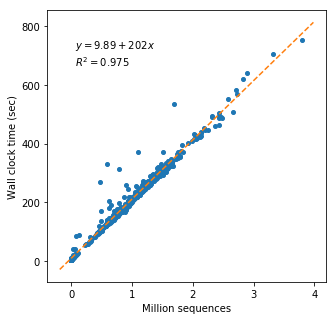

In [6]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
plt.plot(df['mseqs'], df['s'], 'o', markersize=4)
x0, x1 = plt.xlim()
y0 = x0 * reg.slope + reg.intercept
y1 = x1 * reg.slope + reg.intercept
plt.plot([x0, x1], [y0, y1], '--')
plt.text(0.1, 0.8, '$\it{y} = %.3g %+.3g \it{x}$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Million sequences')
plt.ylabel('Wall clock time (sec)');

In [7]:
reg = linregress(df['mseqs'].values, df['mbram'].values)
reg

LinregressResult(slope=0.44711386145708548, intercept=2.9066318382168732, rvalue=0.37098667678108366, pvalue=7.5750394375810717e-25, stderr=0.041826338629199808)

Text(0,0.5,'Maximum memory usage (MB)')

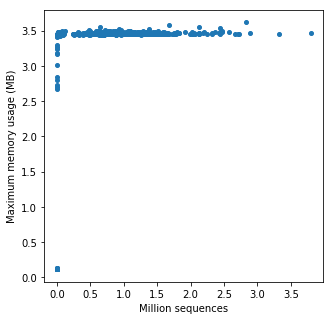

In [8]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
plt.plot(df['mseqs'], df['mbram'], 'o', markersize=4)
plt.xlabel('Million sequences')
plt.ylabel('Maximum memory usage (MB)')